In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_small
from PIL import Image

plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

D:\python\Lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


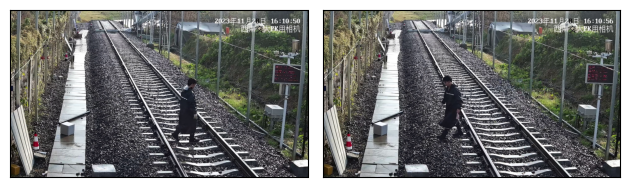

In [2]:
from torchvision.io import read_video
frames, _, _ = read_video('final.mp4')
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

img1_batch = torch.stack([frames[200], frames[350]])
img2_batch = torch.stack([frames[205], frames[355]])

plot(img2_batch)

In [3]:
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [4]:
from torchvision.models.optical_flow import raft_small

model = raft_small(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

D:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


type = <class 'list'>
length = 12 = number of iterations of the model


In [5]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -27.700910568237305, max = 44.053470611572266


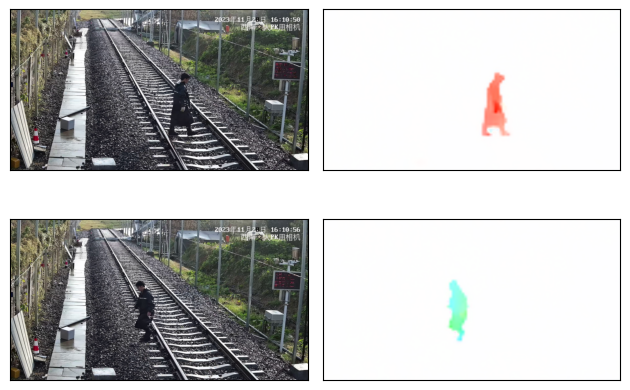

In [6]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [5]:
model = raft_small(pretrained=True, progress=False).to('cuda')
model = model.eval()

In [9]:
input_1 = torch.randn(1,3,224,224).to('cuda')
input_2 = torch.randn(1,3,224,224).to('cuda')

In [11]:
device = 'cuda'

In [15]:
out = model(input_1,input_2)

In [16]:
out[0].shape

torch.Size([1, 2, 224, 224])

In [16]:
from torchvision.models.optical_flow import Raft_Small_Weights
from torchvision.utils import flow_to_image
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_small
from PIL import Image
import cv2
device = 'cuda'
model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

class RaftTool:
    def __init__(self):
        self.weights = Raft_Small_Weights.DEFAULT
        self.transforms = self.weights.transforms()
        
    def preprocess(self,img_1,img_2):
        img_1 = F.resize(img_1,size=[560,960],antialias=False)
        img_2 = F.resize(img_2,size=[560,960],antialias=False)
        return self.transforms(img_1,img_2)

    def infer(self,img1_path,img2_path):
        img_1 = Image.open(img1_path)
        img_2 = Image.open(img2_path)
        img_1,img_2 = self.preprocess(img_1,img_2)
        img_1 = torch.unsqueeze(img_1,0)
        img_2 = torch.unsqueeze(img_2,0)
        list_of_flows = model(img_1.to(device),img_2.to(device))
        predicted_flows = list_of_flows[-1]
        flow_imgs = flow_to_image(predicted_flows)
        predictions = F.to_pil_image(flow_imgs[0].to("cpu"))
        return predictions

In [17]:
raft = RaftTool()

In [25]:
out = raft.infer('30cm_nor/frame_0108.jpg','30cm_nor/frame_0109.jpg')

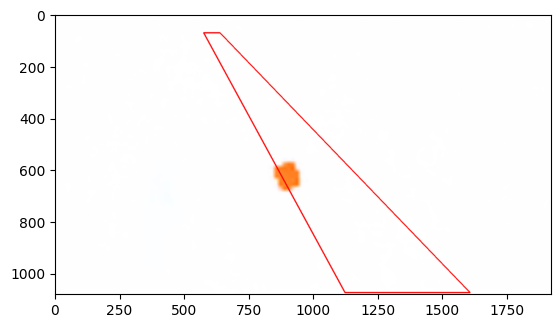

In [26]:
out_array = np.array(out)
threshold = 200
gray_image = cv2.cvtColor(out_array, cv2.COLOR_BGR2GRAY)
out_array = cv2.resize(out_array,(1920,1080))
points = np.array([[574, 72], [1120, 1074], [1603, 1074], [637, 72]], np.int32)
points = points.reshape((-1, 1, 2))
cv2.polylines(out_array, [points], isClosed=True, color=(255, 0, 0), thickness=3)
plt.imshow(out_array)

In [69]:
gray_image = cv2.cvtColor(out_array, cv2.COLOR_BGR2GRAY)

array([252, 252, 255], dtype=uint8)

In [91]:
_, binary_image = cv2.threshold(gray_image, 245, 255, cv2.THRESH_BINARY)

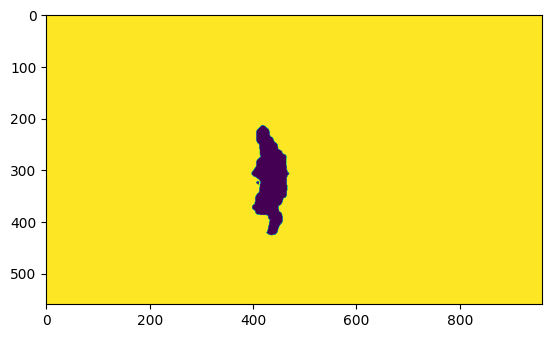

In [92]:
plt.imshow(binary_image)

In [93]:
polygon = np.array([[574, 72], [1120, 1074], [1603, 1074], [637, 72]], np.int32)
polygon = polygon.reshape((-1, 1, 2))

points_in_poly = []
for i in range(1080):
    for j in range(1920):
        dist = cv2.pointPolygonTest(polygon, [j,i], False)
        if dist>0:
            points_in_poly.append([j,i])

In [24]:
import cv2
import os

# 创建保存帧的目录
output_dir = '30cm_nor'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 打开视频文件
video_path = '../Intrusion_Detection/core/video/normal/30cm_10_normal_2.mp4'
cap = cv2.VideoCapture(video_path)

# 检查视频是否成功打开
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# 获取视频的帧率
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps / 4)  # 每500毫秒一帧

# 帧计数器
frame_count = 0
saved_frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # 每隔指定的帧数保存一帧
    if frame_count % frame_interval == 0:
        frame_path = os.path.join(output_dir, f'frame_{saved_frame_count:04d}.jpg')
        cv2.imwrite(frame_path, frame)
        saved_frame_count += 1

    frame_count += 1

# 释放视频捕获对象
cap.release()

print(f"Extracted {saved_frame_count} frames and saved to {output_dir}.")


Extracted 1550 frames and saved to 30cm_nor.
